# CSTR system

This notebook explores solutions to the system discussed in Seborg, Edgar, Melichamp & Doyle "Process Dynamics and Control" (3rd Ed).

![CSTR](../../assets/cstr.png)

## Model
\begin{align}
k &= k_0\exp\left(\frac{-E}{RT}\right)\\
w &=q\rho \\
V\frac{\mathrm{d}c_A}{\mathrm{d}t} &= q(c_{Ai} - c_A) - V k c_A \\
V\rho C\frac{\mathrm{d}T}{\mathrm{d}t} &= wC(T_i - T) + (-\Delta H_R) V k c_A + UA(T_c - T) 
\end{align}

EB: $$\frac{dE}{dt} = E_{in} - E_{out}$$

MB: $$\frac{dm}{dt} = \dot m_{in} - \dot m_{out}$$

CB: $$\frac{dN_A}{dt} = N_{A,in} - N_{A, out} + N_{A, \text{gen}} - N_{A, \text{consumed}}$$


In [1]:
import numpy
import scipy
import scipy.optimize
import scipy.integrate

Parameter values from Table 2.3

In [2]:
q = 100  # L/min
cA_i = 1  # mol/L
T_i = 350  # K 
V = 100  # L
rho = 1000 # g/L
C = 0.239 # J/(g K)
Hr = -5e4  # J/(g K)
E_over_R = 8750  # K
k0 = 7.2e10  # 1/min
UA = 5e4  # J/(min K)

This is the intial value of the input $T_c$

In [3]:
Tc = Tc0 = 300  # K

These are the initial values of the states given in the question. Notice that these are not 100 % accurate. When we simulate using these values, we don't get a perfect straight line (derivatives equal to zero) as we should when using the steady state values.

In [4]:
cA0 = 0.5  # mol/L
T0 = 350  # K 

We define the function to calculate the derivatives here.

In [5]:
def intsys(t, x):
    cA, T = x
    k = k0*numpy.exp(-E_over_R/T)
    w = q*rho
    dcAdt = q*(cA_i - cA)/V - k*cA
    dTdt = 1/(V*rho*C)*(w*C*(T_i - T) - Hr*V*k*cA + UA*(Tc - T))
    return dcAdt, dTdt

In [6]:
x0 = [cA0, T0]

Let's see what the derivatives look like at this "steady state"

In [7]:
intsys(0, x0)

(3.40208612952253e-05, -0.007117334999003795)

That doesn't seem very close to zero...

Now, let's simulate

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
tspan = (0, 10)
t = numpy.linspace(*tspan, 1000)

In [10]:
def simulate():
    r = scipy.integrate.solve_ivp(intsys, tspan, x0, t_eval=t)
    return r.y

In [11]:
cA, T = simulate()

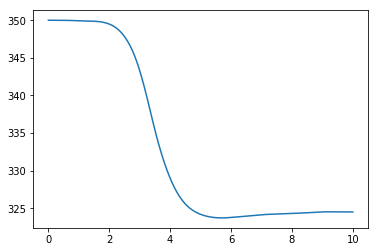

In [12]:
plt.plot(t, T)
plt.show()

We see a significant deviation from the straight line we were expecting!

## Solve for steady state
Now, let's solve for a better initial value by setting the derivatives equal to zero

In [13]:
def ss(x):
    """ This wrapper function simply calls intsys with a zero time"""
    return intsys(0, x)

We use fsolve to solve for a new steady state

In [14]:
x0 = scipy.optimize.fsolve(ss, x0)

Let's check that:

In [15]:
ss(x0)

(3.7614356074300304e-13, -7.879222786077396e-11)

Much better, let's simulate:

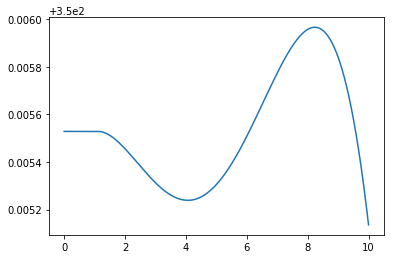

In [16]:
cA, T = simulate()
plt.plot(t, T)
plt.show()

What happened there? It seems as though these equations are quite hard to balance perfectly at the steady state, since starting quite close to zero derivatives still gave some deviation toward the end. Nonlinear differential equations often exhibit this high sensitivity to the initial value.

But look closely and you can see that the axis is strangely indicated. When we zoom out just a little the solution is more clear:

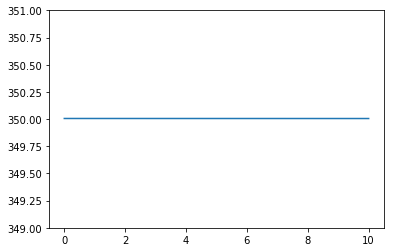

In [17]:
cA, T = simulate()
plt.plot(t, T)
plt.ylim(349, 351)
plt.show()

I'd say that's good enough.

Now we are ready to reproduce the figure

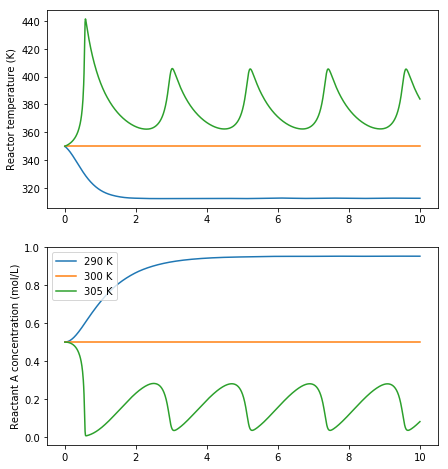

In [18]:
fig, (axT, axcA) = plt.subplots(2, 1, figsize=(7, 8))
for Tc in [290, 300, 305]:
    cA, T = simulate()
    axT.plot(t, T, label='{} K'.format(Tc))
    axT.set_ylabel('Reactor temperature (K)')
    axcA.plot(t, cA, label='{} K'.format(Tc))    
    axcA.set_ylabel('Reactant A concentration (mol/L)')
axcA.legend()
plt.show()

## Nonlinear behaviour

Nonlinear differential equations like this can exhibit very strange behaviour. We may expect that increasing the cooling water temperature will always increase the reactor temperature, measured after a certain amount of time, but the oscillatory behaviour we see in the graphs above give us a clue that everything may not be as simple as it appears.

In [19]:
sol = scipy.integrate.solve_ivp(intsys, tspan, x0)

In [20]:
Tends = []
Tcs = numpy.linspace(300, 310, 1000)
for Tc in Tcs:
    sol = scipy.integrate.solve_ivp(intsys, tspan, x0)
    T = sol.y[-1]
    Tends.append(T[-1])

/Users/alchemyst/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:141: RuntimeWarning: invalid value encountered in true_divide
  error_norm = norm(error / scale)
/Users/alchemyst/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/Users/alchemyst/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """


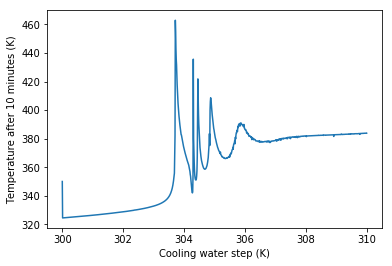

In [21]:
plt.plot(Tcs, Tends)
plt.ylabel('Temperature after 10 minutes (K)')
plt.xlabel('Cooling water step (K)')
plt.show()

We can see that there is often no easy explanation to system behavour like "Making x bigger will make y bigger". For nonlinear systems the answer to questions the direction of an effect is often very much "it depends"